This notebook applies scipy's [hierarchical clustering package](https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html#) to the `all-the-news-25k.csv` dataset.

## Setup

In [58]:
import pandas as pd

df = pd.read_csv('data/all-the-news-25K.csv', low_memory=False, parse_dates=['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         25000 non-null  datetime64[ns]
 1   year         25000 non-null  int64         
 2   month        25000 non-null  float64       
 3   day          25000 non-null  int64         
 4   title        25000 non-null  object        
 5   article      25000 non-null  object        
 6   section      25000 non-null  object        
 7   publication  25000 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 1.5+ MB


In [2]:
df.sample(5)

,date,year,month,day,title,article,section,publication
3761,2018-07-13 00:00:00,2018,7.0,13,Trade policy uncertainty could bolster U.S. de...,NEW YORK (Reuters) - As the United States ramp...,business,Reuters
19478,2017-08-03 00:00:00,2017,8.0,3,Facebook Stories are coming to the desktop,"Facebook Stories, one of several Facebook-made...",technology,The Verge
5563,2019-06-26 00:00:00,2019,6.0,26,U.S. extends divestiture deadline for sanction...,WASHINGTON (Reuters) - The U.S. Treasury said ...,business,Reuters
23093,2018-02-11 15:21:00,2018,2.0,11,Amy Schumer Smooches Chris Fischer in New Photo,Smooch there it is! Amy Schumer and chef Chris...,movies,People
19682,2017-09-10 00:00:00,2017,9.0,10,AI learns to re-create Super Mario Bros. by wa...,"Usually, when we get AI systems to watch video...",technology,The Verge


Use [sklearn.feature_extraction.text.CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer) to convert to a matrix of token counts:

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words="english")
X = vec.fit_transform(df['article'])

type(X), X.shape

(scipy.sparse.csr.csr_matrix, (25000, 1000))

Use [scipy.sparse.csr_matrix.todense](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.todense.html) to convert from a sparse to dense matrix:

In [4]:
X_dense = X.todense()
type(X_dense), X_dense.shape

(numpy.matrix, (25000, 1000))

## Hierarchical Clustering

Perform hierarchical/agglomerative clustering; see [scipy documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage).

In [5]:
%%time

from scipy.cluster.hierarchy import linkage, dendrogram

Z = linkage(X_dense, method='ward')

CPU times: user 2min 41s, sys: 1.96 s, total: 2min 43s
Wall time: 2min 43s


The cophenetic correlation measures "how faithfully a dendrogram preserves the pairwise distances between the original unmodeled data points" — see [Wikipedia](https://en.wikipedia.org/wiki/Cophenetic_correlation). The closer to 1, the better the clustering preserves the original distances.

In [6]:
%%time

from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

c, coph_dists = cophenet(Z, pdist(X_dense))
c

CPU times: user 2min 26s, sys: 4.56 s, total: 2min 31s
Wall time: 2min 31s


0.4974043405964257

0.497 isn't great. I'm going to try other linkage methods and metrics.

In [11]:
%%time

Z_single_cityblock = linkage(X_dense, method='single', metric='cityblock')
c_single_cityblock, _ = cophenet(Z_single_cityblock, pdist(X_dense))
print(f"single method and cityblock metric: {c_single_cityblock}")

single method and cityblock metric: 0.9257020466030761
CPU times: user 5min 59s, sys: 6.77 s, total: 6min 6s
Wall time: 6min 7s


In [12]:
%%time

Z_single_euclidean = linkage(X_dense, method='single', metric='euclidean')
c_single_euclidean, _ = cophenet(Z_single_euclidean, pdist(X_dense))
print(f"single method and euclidean metric: {c_single_euclidean}")

single method and euclidean metric: 0.9638518034815363
CPU times: user 5min 3s, sys: 6.43 s, total: 5min 10s
Wall time: 5min 11s


In [13]:
%%time

Z_complete_euclidean = linkage(X_dense, method='complete', metric='euclidean')
c_complete_euclidean, _ = cophenet(Z_complete_euclidean, pdist(X_dense))
print(f"complete method and euclidean metric: {c_complete_euclidean}")

complete method and euclidean metric: 0.7895273877834017
CPU times: user 5min 21s, sys: 7.17 s, total: 5min 28s
Wall time: 5min 29s


Looks like the `single` method with `euclidean` metric gives us the best cophenetic correlation (0.96) so we'll proceed with that one.

The `linkage()` function above uses my specified method (`ward`) to calculate the distances of the clusters. It starts off with every data point as a singleton cluster. In each iteration, it will merge the two clusters with the smallest distance.

`Z[i]` tells us which clusters were merged in the i-th iteration, with this format: `[index1, index2, distance, sample_count]`.

In the first iteration, we see that data samples with indices 13542 and 14851 were merged since they had a distance of 0, creating a cluster with a count of 2:

In [14]:
Z_single_euclidean[0]

array([1.3542e+04, 1.3776e+04, 0.0000e+00, 2.0000e+00])

Let's look at the first 20 iterations:

In [21]:
Z_single_euclidean[:20]

array([[1.3542e+04, 1.3776e+04, 0.0000e+00, 2.0000e+00],
       [1.4618e+04, 2.5000e+04, 0.0000e+00, 3.0000e+00],
       [1.4683e+04, 1.4812e+04, 0.0000e+00, 2.0000e+00],
       [1.4778e+04, 1.4851e+04, 0.0000e+00, 2.0000e+00],
       [9.8790e+03, 1.0968e+04, 0.0000e+00, 2.0000e+00],
       [1.4060e+04, 2.5004e+04, 0.0000e+00, 3.0000e+00],
       [2.0678e+04, 2.5005e+04, 0.0000e+00, 4.0000e+00],
       [1.0979e+04, 1.1671e+04, 0.0000e+00, 2.0000e+00],
       [1.7440e+03, 7.9730e+03, 0.0000e+00, 2.0000e+00],
       [9.6660e+03, 2.5008e+04, 0.0000e+00, 3.0000e+00],
       [9.9080e+03, 2.5009e+04, 0.0000e+00, 4.0000e+00],
       [4.7880e+03, 8.6360e+03, 0.0000e+00, 2.0000e+00],
       [1.0324e+04, 1.1492e+04, 0.0000e+00, 2.0000e+00],
       [5.1260e+03, 7.7710e+03, 0.0000e+00, 2.0000e+00],
       [6.6400e+02, 1.8890e+03, 0.0000e+00, 2.0000e+00],
       [6.3100e+02, 5.6430e+03, 0.0000e+00, 2.0000e+00],
       [1.2190e+03, 9.9390e+03, 0.0000e+00, 2.0000e+00],
       [1.0246e+04, 1.2086e+04,

We see that starting in the 2nd iteration, there is a cluster of size 3, which means we merged the cluster from the first iteration with an original sample.

In the last 9 iterations, the sample count is 2, so they are all merging original samples only.

## Dendrogram

A dendrogram is a tree visualization to see the order and distances of merges that occur during hierarchical clustering.

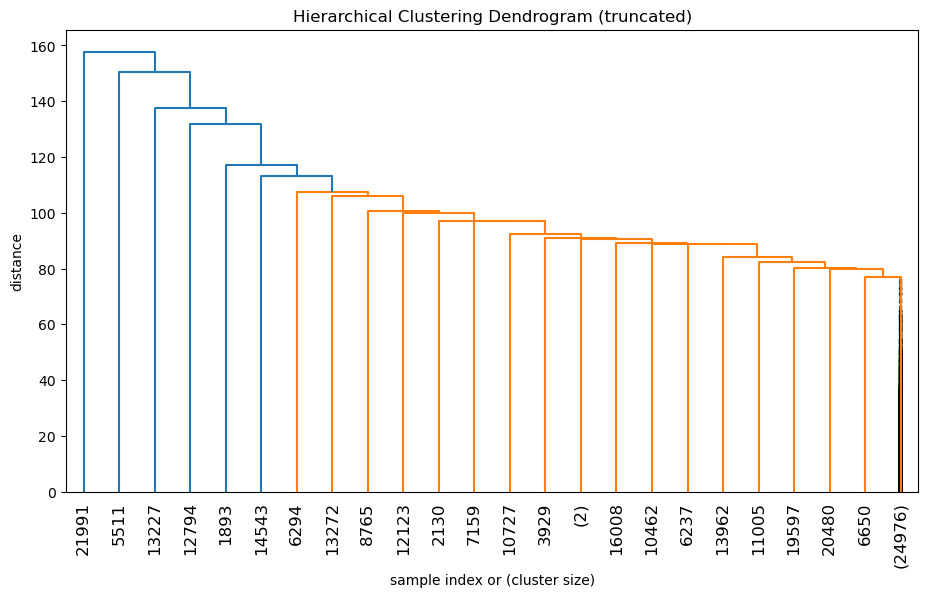

CPU times: user 1min 6s, sys: 322 ms, total: 1min 6s
Wall time: 1min 6s


In [27]:
%%time

import sys
import matplotlib.pyplot as plt

# Increase recursion limit
sys.setrecursionlimit(100000)

# Plot dendrogram
fig, ax = plt.subplots(figsize=(11, 6))
plt.title("Hierarchical Clustering Dendrogram (truncated)")
dendrogram(
    Z_single_euclidean,
    truncate_mode='lastp', # show only the last p merged clusters
    p=24, # show only the last p merged clusters
    leaf_rotation=90.0,
    leaf_font_size=12.0,
    show_contracted=True, # to get a distribution impression in truncated branches
)
plt.xlabel("sample index or (cluster size)")
plt.ylabel("distance")
plt.show()

That doesn't look great; it's just separating every sample from each other instead of clustering them.

Let's try the Ward linkage with euclidean metric instead:

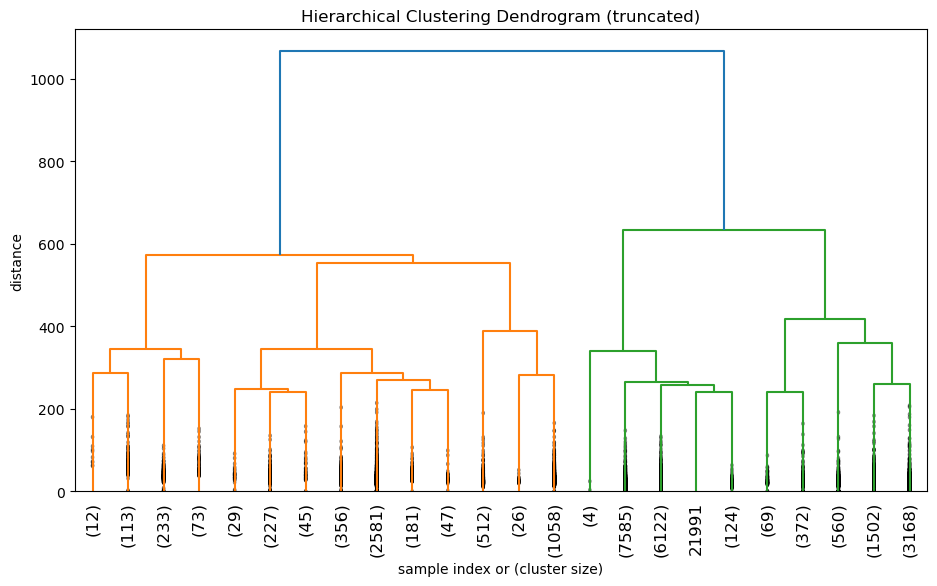

In [28]:
fig, ax = plt.subplots(figsize=(11, 6))
plt.title("Hierarchical Clustering Dendrogram (truncated)")
dendrogram(
    Z,
    truncate_mode='lastp', # show only the last p merged clusters
    p=24, # show only the last p merged clusters
    leaf_rotation=90.0,
    leaf_font_size=12.0,
    show_contracted=True, # to get a distribution impression in truncated branches
)
plt.xlabel("sample index or (cluster size)")
plt.ylabel("distance")
plt.show()

That looks better, with a clear hierarchy of clusters.

## Retrieve Clusters

Use [scipy.cluster.hierarchy.fcluster](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster) to retrieve cluster membership.

In [38]:
from scipy.cluster.hierarchy import fcluster
import numpy as np

# Retrieve clusters based on 5 maximum clusters
clusters = fcluster(Z, t=5, criterion='maxclust')

# Check how many clusters we have
np.unique(clusters)

array([1, 2, 3, 4, 5], dtype=int32)

Add cluster membership to the original DataFrame.

In [59]:
df['cluster'] = clusters

## Compare Clusters With 'Section' Column

In [60]:
df.sample(5)

,date,year,month,day,title,article,section,publication,cluster
21304,2018-07-27 01:12:00,2018,7.0,27,Jonathan Rhys Meyers Says His Wife Is a 'Super...,Jonathan Rhys Meyers is praising his wife afte...,movies,People,4
7171,2019-06-26 00:00:00,2019,6.0,26,Trump suggests EU out of line in suing U.S. te...,WASHINGTON (Reuters) - U.S. President Donald T...,technology,Reuters,5
24366,2019-06-17 22:25:00,2019,6.0,17,MTV Movie & TV Awards: Noah Centineo & Lana Co...,Netflix’s heartthrobs are winners! Noah Centin...,movies,People,4
18904,2017-04-05 00:00:00,2017,4.0,5,Facebook will use photo matching to stop reven...,Facebook unveiled a new system today that it h...,technology,The Verge,5
21567,2018-03-21 15:04:00,2018,3.0,21,Margot Robbie's Hilarious Reaction to Her Brot...,Margot Robbie had a bit of a shock while promo...,movies,People,4


Count how many articles from each cluster belong to each `section`:

In [57]:
df[df['section'] == 'healthcare']['cluster'].value_counts()

2    2879
4    1749
1     279
5      62
3      31
Name: cluster, dtype: int64

In [61]:
df[df['section'] == 'movies']['cluster'].value_counts()

4    4755
2     192
1      22
5      16
3      15
Name: cluster, dtype: int64

In [62]:
df[df['section'] == 'technology']['cluster'].value_counts()

4    3129
5    1731
2     128
1       9
3       3
Name: cluster, dtype: int64

In [63]:
df[df['section'] == 'sports']['cluster'].value_counts()

4    3043
3    1545
2     240
1     118
5      54
Name: cluster, dtype: int64

In [64]:
df[df['section'] == 'business']['cluster'].value_counts()

5    3808
4    1160
2      27
1       3
3       2
Name: cluster, dtype: int64

It looks like:
- cluster #1 is small and has weak representation in all of the different sections, maybe articles in this cluster don't really fit with the other section themes
- cluster #2 is most strongly correlated with healthcare
- cluster #3 is most strongly correlated with sports
- cluster #4 is the largest cluster and has strong representation in all of the different sections
- cluster #5 is mostly strongly correlated with business and technology